## Proximal Policy Optimization 

В практической реализации существует два варианта реализации алгоритма PPO:
* выполняет обновление, ограниченное KL, как TRPO, но штрафует KL-расхождение в целевой функции вместо того, чтобы делать его жестким ограничением, и автоматически регулирует коэффициент штрафа в процессе обучения, чтобы он масштабировался соответствующим образом.
* не содержит в целевой функции члена KL-дивергенции и вообще не имеет ограничения. Вместо этого полагается на специализированный клиппинг 

<img src="https://spinningup.openai.com/en/latest/_images/math/e62a8971472597f4b014c2da064f636ffe365ba3.svg">

Спойлер: клиппинг - не самое главное в PPO, как это могло показаться на первый взгляд. Алгоритм PPO работает во многом и за счет небольших дополнительных улучшений. Подробнее: https://arxiv.org/pdf/2005.12729.pdf

## Полистайте на досуге:
https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/

<iframe src="https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/" 
        width="100%" 
        height="600px" 
        style="border: none;">
</iframe>


### Задание 1: Заполните пропуски в алгоритме

In [2]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !apt -qq update -y
    !apt -qq install swig -y
    !pip -q install box2d-py
    !pip -q install "gymnasium[classic-control, box2d, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

In [3]:
import gymnasium as gym
import numpy as np
from IPython.display import HTML
from base64 import b64encode
import glob
import os
from gymnasium.wrappers import RecordVideo
import matplotlib.pyplot as plt
import torch
%matplotlib inline

def show_video(video_path):
    """
    Показывает видео в Jupyter notebook
    """
    video_files = glob.glob(os.path.join(video_path, "*.mp4"))
    if not video_files:
        print("No video files found")
        return
    
    latest_video = max(video_files, key=os.path.getctime)
    
    with open(latest_video, 'rb') as f:
        video_data = f.read()
    video_base64 = b64encode(video_data).decode()
    
    video_html = f"""
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{video_base64}" type="video/mp4">
    </video>
    """
    
    return HTML(video_html)

def visualize_ppo_policy(ppo, env_name="CartPole-v1", video_path="videos/ppo-cartpole/", num_episodes=3):
    """
    Визуализирует поведение обученной PPO стратегии
    
    Args:
        ppo: Обученная модель PPO
        env_name: Название среды Gymnasium
        video_path: Путь для сохранения видео
        num_episodes: Количество эпизодов для визуализации
    """
    os.makedirs(video_path, exist_ok=True)
    
    env = gym.make(env_name, render_mode='rgb_array')
    env = RecordVideo(env, video_path, episode_trigger=lambda x: True)
    
    episode_rewards = []
    episode_lengths = []
    
    for i_episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        steps = 0
        
        while not done:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).to(device)
                action_probs = ppo.target_policy.module.action_layer(state_tensor)
                dist = torch.distributions.Categorical(logits=action_probs)
                action = dist.sample().item()
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            
            total_reward += reward
            steps += 1
            done = terminated or truncated
            state = next_state
        
        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
        print(f"Эпизод {i_episode+1}: награда = {total_reward}, длина = {steps}")
    
    env.close()
    
    print(f"\nСредняя награда: {np.mean(episode_rewards):.1f}")
    print(f"Средняя длина эпизода: {np.mean(episode_lengths):.1f}")
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.bar(range(1, num_episodes+1), episode_rewards)
    plt.xlabel('Эпизод')
    plt.ylabel('Суммарная награда')
    plt.title('Награды по эпизодам')
    
    plt.subplot(1, 2, 2)
    plt.bar(range(1, num_episodes+1), episode_lengths)
    plt.xlabel('Эпизод')
    plt.ylabel('Длина эпизода')
    plt.title('Длина эпизодов')
    plt.tight_layout()
    plt.show()
    
    return show_video(video_path)

In [4]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
import gymnasium as gym
import numpy as np

# If you have an Apple Silicon Mac, you can use the MPS backend:
# read https://developer.apple.com/metal/pytorch/
# pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu
device = (
    torch.device("cuda:0") if torch.cuda.is_available() # for NVIDIA GPUs
    # else torch.device("mps") if torch.backends.mps.is_available() # for Apple Silicon Macs
    else torch.device("cpu")
)

print(device)

cpu


In [5]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
        self.is_truncateds = []

    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]
        del self.is_truncateds[:]

### Сеть Actor-Critic

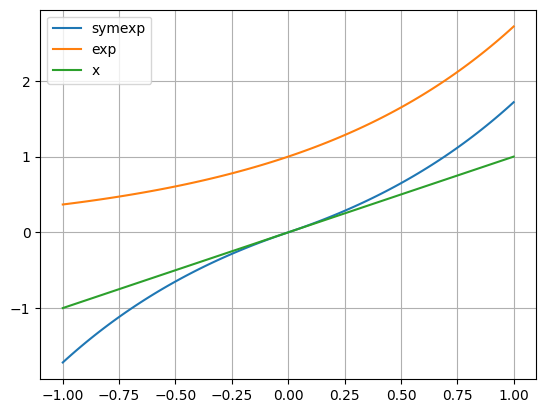

In [6]:
import matplotlib.pyplot as plt
x = np.linspace(-1, 1, 100)
plt.plot(x, np.sign(x) * (np.exp(np.abs(x)) - 1.0), label='symexp')
plt.plot(x, np.exp(x), label='exp')
plt.plot(x, x, label='x')
plt.grid()
plt.legend()
plt.show()

In [7]:
def symexp(x):
    return torch.sign(x) * (torch.exp(torch.abs(x)) - 1.0)

class SymExpModule(nn.Module):    
    def forward(self, x):
        return symexp(x)

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden):
        super(ActorCritic, self).__init__()

        # actor: 2 hidden + output
        # self.action_layer = nn.Sequential(...)
        # NB: на выходе далее будем ожидать логиты, а не вероятности!
        # Это сеть актора (policy network)
        """<codehere>"""
        self.action_layer = nn.Sequential(
            nn.Linear(state_dim, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, action_dim),
            SymExpModule(),
        )

        """</codehere>"""

        # critic: 2 hidden + output
        # self.value_layer = nn.Sequential(...)
        """<codehere>"""
        self.value_layer = nn.Sequential(
            nn.Linear(state_dim, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, 1)
        )
        """</codehere>"""

    def forward(self, *args, **kwargs):
        return self.act(*args, **kwargs)

    def act(self, state, memory):
        # Метод act принимает состояние и объект памяти, и возвращает действие.
        state = torch.from_numpy(state).float().to(device)
        
        action_logits = self.action_layer(state)
        dist = Categorical(logits=action_logits)

        """Если действия непрерывные
        mean, std = self.action_layer(state).chunk(2, dim=-1)
        std = log_std.exp()
        dist = Normal(mean, std)
        action = dist.sample()
        """


        action = dist.sample()
        
        # сохраняем в память: state, action, log_prob(action)
        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(dist.log_prob(action))

        return action.item()

    def evaluate(self, state, action):
        # Метод evaluate используется при обновлении стратегии. 

        action_logits = self.action_layer(state)
        dist = Categorical(logits=action_logits)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        
        state_value = self.value_layer(state)

        return action_logprobs, torch.squeeze(state_value), dist_entropy

### PPO policy

In [8]:
from torch.optim.swa_utils import AveragedModel
# source Stochastic Weights Averaging (SWA): https://arxiv.org/pdf/1803.05407
# https://pytorch.org/docs/stable/generated/torch.optim.swa_utils.AveragedModel.html


# Здесь определяется класс PPO с конструктором, принимающим следующие параметры:
class PPO:
    def __init__(
        self, 
        state_dim, 
        action_dim,
        n_latent_var,
        lr,
        betas,
        gamma,
        K_epochs,
        eps_clip,
        ema_gamma=0.9
    ):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs

        self.policy = ActorCritic(state_dim, action_dim, n_latent_var).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)
        self.MseLoss = nn.MSELoss()
        
        # Заведем также целевую стратегию: она будет собирать опыт в среде и использоваться
        # после обучения. Шаги обновления будут поступать в нее с задержкой — 
        # через EMA (exponential moving average) обновления:
        # W^{target}_{t+1} = gamma_{ema} * W^{target}_t + (1 - gamma_{ema}) * W
        ema_avg = lambda avg_model_parameter, model_parameter, _: (
            ema_gamma * avg_model_parameter + (1.0 - ema_gamma) * model_parameter
        )

        self.target_policy = AveragedModel(self.policy, avg_fn=ema_avg)

    # Метод update выполняет обновление параметров модели на основе собранного опыта. 
    def update(self, memory):
        old_states = torch.stack(memory.states).to(device).detach()
        old_actions = torch.stack(memory.actions).to(device).detach()
        old_logprobs = torch.stack(memory.logprobs).to(device).detach()

        # Посчитайте отдачи:
        returns = []
        """<codehere>"""
        old_state_values = self.policy.value_layer(old_states).squeeze()
        ret = old_state_values[-1]
        for reward, is_terminal, is_truncated, v_s in zip(
            reversed(memory.rewards), reversed(memory.is_terminals),
            reversed(memory.is_truncateds), reversed(old_state_values)
        ):
            if is_terminal:
                ret = 0
            elif is_truncated:
                ret = v_s

            ret = reward + (self.gamma * ret)
            returns.append(ret)
        """</codehere>"""

        returns = returns[::-1]
        returns = torch.tensor(returns, dtype=torch.float32).to(device)
        # выполните нормализацию отдач
        # rewards = 
        """<codehere>"""
        returns = (returns - returns.mean() / (returns.std() + 1e-5))
        # returns = returns / 100.
        """</codehere>"""

        # Здесь начинается цикл оптимизации, который выполняется K_epochs раз (например, 4 раза). 
        for _ in range(self.K_epochs):

            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # ratios = 
            """<codehere>"""
            # ratios = pi_theta / pi_theta_old
            # ratios = torch.exp(logprobs) / torch.exp(old_logprobs).detach()
            ratios = torch.exp(logprobs - old_logprobs.detach())
            """</codehere>"""
    
            # advantages = 
            """<codehere>"""
            # A(s,a) = Q(s, a) - V(s)
            advantages = returns - state_values.detach()
            """</codehere>"""
            
            # Находим surrogate loss:
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 1.0 / self.K_epochs * self.MseLoss(state_values, returns) - 0.001 * dist_entropy

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
        # делаем шаг обновления целевой стратегии
        self.target_policy.update_parameters(self.policy)

### Основной цикл

In [15]:
env_name = "CartPole-v1"
# env_name = "LunarLander-v3"
# env_name = "MountainCar-v0"

env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
render = False
solved_reward = 500  # останавливаемся если avg_reward > solved_reward
log_interval = 100  # печатаем avg reward в интервале 
max_episodes = 50000  # количество эпизодов обучения
max_timesteps = 500  # максимальное кол-во шагов в эпизоде
n_latent_var = 32  # кол-во переменных в скрытых слоях
update_timestep = 2000  # обновляем policy каждые n шагов
lr = 0.005 # learning rate
betas = (0.9, 0.999) # betas для adam optimizer
gamma = 0.99  # discount factor
ema_gamma = 0.1  # скорость обновления целевой стратегии (увеличить, если нестабильно)
K_epochs = 4  # количество эпох обновления policy
eps_clip = 0.1  # clip параметр для PPO
random_seed = None

if random_seed:
    torch.manual_seed(random_seed)
    env.seed(random_seed)

memory = Memory()
ppo = PPO(
    state_dim, action_dim, n_latent_var, lr, betas, gamma, K_epochs, eps_clip,
    ema_gamma=ema_gamma
)
print(lr, betas)

# переменные для логирования
running_reward = 0
avg_length = 0
timestep = 0

# цикл обучения
for i_episode in range(1, max_episodes + 1):
    state, _ = env.reset()
    for t in range(max_timesteps):
        timestep += 1

        # используем policy_old для выбора действия
        action = ppo.target_policy(state, memory)
        state, reward, terminated, truncated, _ = env.step(action)
        
        # сохраняем награды и флаги терминальных состояний:
        memory.rewards.append(reward)
        memory.is_terminals.append(terminated)
        memory.is_truncateds.append(truncated)

        # выполняем обновление
        if timestep == update_timestep:
            ppo.update(memory)
            memory.clear_memory()
            timestep = 0

        running_reward += reward
        if render:
            env.render()
        if terminated or truncated:
            break

    avg_length += t

    # останавливаемся, если avg_reward > solved_reward
    if running_reward >= (log_interval * solved_reward):
        print("########## Принято! ##########")
        break

    # логирование
    if i_episode % log_interval == 0:
        avg_length /= log_interval
        running_reward /= log_interval

        print(
            f'Episode {i_episode}'
            f' \t avg length: {avg_length:.1f}'
            f' \t reward: {running_reward:.1f}'
        )
        running_reward = 0
        avg_length = 0

0.005 (0.9, 0.999)
Episode 100 	 avg length: 23.7 	 reward: 24.7
Episode 200 	 avg length: 28.0 	 reward: 29.0
Episode 300 	 avg length: 41.6 	 reward: 42.6
Episode 400 	 avg length: 120.0 	 reward: 121.0
Episode 500 	 avg length: 229.5 	 reward: 230.5
Episode 600 	 avg length: 448.7 	 reward: 449.7
Episode 700 	 avg length: 489.7 	 reward: 490.7
Episode 800 	 avg length: 496.0 	 reward: 497.0
Episode 900 	 avg length: 499.0 	 reward: 500.0
########## Принято! ##########


In [16]:
def visualize_value_function(ppo, env_name="CartPole-v1"):
    """
    Визуализирует функцию ценности (value function) для CartPole
    
    Args:
        ppo: Обученная модель PPO
        env_name: Название среды (работает только для CartPole)
    """
    if "CartPole" not in env_name:
        print("Визуализация функции ценности поддерживается только для CartPole")
        return
    
    cart_position = np.linspace(-2.4, 2.4, 50)
    cart_velocity = np.linspace(-4, 4, 50)
    pole_angle = np.linspace(-0.2, 0.2, 50)
    pole_velocity = np.linspace(-4, 4, 50)
    
    fixed_cart_velocity = 0.0
    fixed_pole_velocity = 0.0
    
    X, Y = np.meshgrid(cart_position, pole_angle)
    Z = np.zeros_like(X)
    
    # значения функции ценности
    for i, cp in enumerate(cart_position):
        for j, pa in enumerate(pole_angle):
            state = np.array([cp, fixed_cart_velocity, pa, fixed_pole_velocity])
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).to(device)
                value = ppo.policy.value_layer(state_tensor).item()
                Z[j, i] = value
    
    plt.figure(figsize=(5, 4))
    plt.pcolormesh(X, Y, Z, shading='auto', cmap='viridis')
    plt.colorbar(label='Значение функции ценности')
    plt.xlabel('Позиция тележки')
    plt.ylabel('Угол шеста')
    plt.title('Функция ценности PPO для CartPole')
    plt.tight_layout()
    plt.show()

def visualize_policy_distribution(ppo, env_name="CartPole-v1"):
    """
    Визуализирует распределение вероятностей действий для CartPole
    
    Args:
        ppo: Обученная модель PPO
        env_name: Название среды (работает только для CartPole)
    """
    if "CartPole" not in env_name:
        print("Визуализация распределения действий поддерживается только для CartPole")
        return
    
    cart_position = np.linspace(-2.4, 2.4, 50)
    pole_angle = np.linspace(-0.2, 0.2, 50)
    
    fixed_cart_velocity = 0.0
    fixed_pole_velocity = 0.0
    
    X, Y = np.meshgrid(cart_position, pole_angle)
    Z = np.zeros_like(X)  # Вероятность действия "вправо"
    
    for i, cp in enumerate(cart_position):
        for j, pa in enumerate(pole_angle):
            state = np.array([cp, fixed_cart_velocity, pa, fixed_pole_velocity])
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).to(device)
                action_probs = ppo.target_policy.module.action_layer(state_tensor)
                action_probs = torch.softmax(action_probs, dim=-1)
                # Вероятность действия "вправо" (индекс 1)
                Z[j, i] = action_probs[1].item()
    
    plt.figure(figsize=(5, 4))
    plt.pcolormesh(X, Y, Z, shading='auto', cmap='coolwarm', vmin=0, vmax=1)
    plt.colorbar(label='Вероятность действия "вправо"')
    plt.xlabel('Позиция тележки')
    plt.ylabel('Угол шеста')
    plt.title('Распределение вероятностей действий PPO для CartPole')
    
    # рисуем контур, где вероятности равны 0.5
    plt.contour(X, Y, Z, levels=[0.5], colors='black', linestyles='dashed')
    plt.tight_layout()
    plt.show()

def plot_training_history(rewards_history, lengths_history, window=100):
    """
    Строит графики обучения на основе истории наград и длин эпизодов
    
    Args:
        rewards_history: История наград по эпизодам
        lengths_history: История длин эпизодов
        window: Размер окна для скользящего среднего
    """
    def moving_average(data, window):
        return np.convolve(data, np.ones(window)/window, mode='valid')
    
    rewards_smoothed = moving_average(rewards_history, window)
    lengths_smoothed = moving_average(lengths_history, window)
    
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(rewards_history, alpha=0.3, color='blue')
    plt.plot(np.arange(window-1, len(rewards_history)), rewards_smoothed, color='blue')
    plt.xlabel('Эпизод')
    plt.ylabel('Награда')
    plt.title(f'Награды (скользящее среднее: {window})')
    
    plt.subplot(1, 2, 2)
    plt.plot(lengths_history, alpha=0.3, color='green')
    plt.plot(np.arange(window-1, len(lengths_history)), lengths_smoothed, color='green')
    plt.xlabel('Эпизод')
    plt.ylabel('Длина эпизода')
    plt.title(f'Длины эпизодов (скользящее среднее: {window})')
    
    plt.tight_layout()
    plt.show()

/opt/miniconda3/envs/q-learning/lib/python3.9/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/kurise/Work/AI-Masters/RL/seminar-6-ppo/videos/ppo-cartpole folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Эпизод 1: награда = 500.0, длина = 500
Эпизод 2: награда = 500.0, длина = 500
Эпизод 3: награда = 500.0, длина = 500

Средняя награда: 500.0
Средняя длина эпизода: 500.0


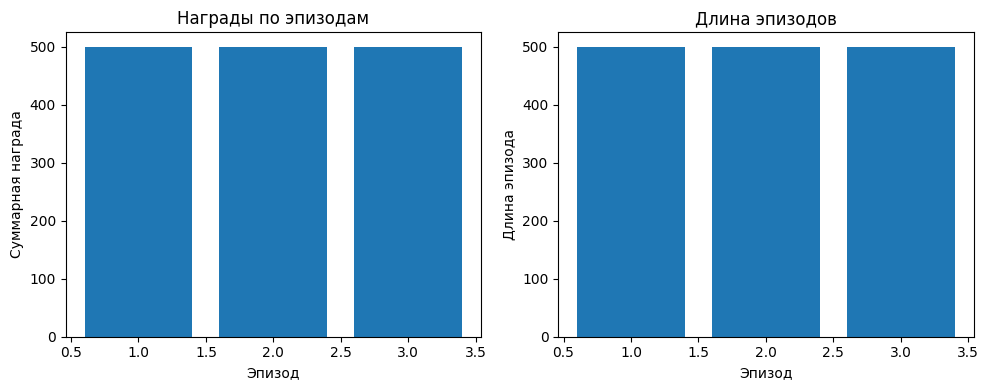

In [17]:
# Пример использования:
# Предполагается, что у нас уже есть обученная ранее кодом выше модель ppo и история обучения

# Визуализация поведения обученной модели
visualize_ppo_policy(ppo, env_name="CartPole-v1", video_path="videos/ppo-cartpole/")

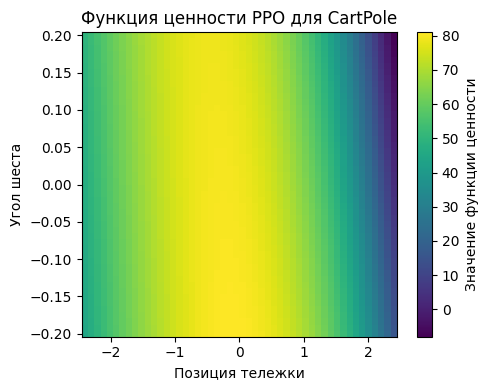

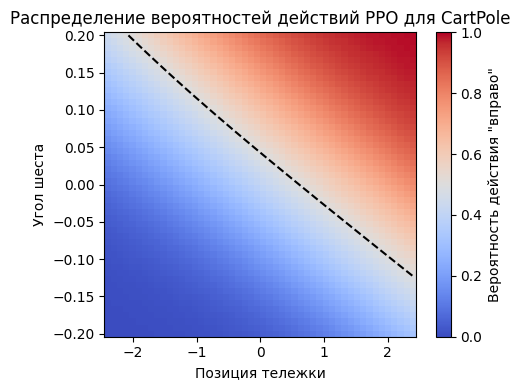

In [18]:
# Визуализация функции ценности
visualize_value_function(ppo)

# Визуализация распределения вероятностей действий
visualize_policy_distribution(ppo)

# Если у вас есть история обучения, можно построить графики
# rewards_history = [...]  # Список наград по эпизодам
# lengths_history = [...]  # Список длин эпизодов
# plot_training_history(rewards_history, lengths_history)

In [19]:
import gymnasium as gym
import numpy as np
import torch
from IPython.display import HTML
from base64 import b64encode
import glob
import os
from gymnasium.wrappers import RecordVideo
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_action_value_landscape(ppo, env_name="CartPole-v1"):
    """
    Визуализирует ландшафт значений действий для CartPole в 3D
    
    Args:
        ppo: Обученная модель PPO
        env_name: Название среды (работает только для CartPole)
    """
    if "CartPole" not in env_name:
        print("Визуализация ландшафта значений поддерживается только для CartPole")
        return
    
    from mpl_toolkits.mplot3d import Axes3D
    
    cart_position = np.linspace(-2.4, 2.4, 30)
    pole_angle = np.linspace(-0.2, 0.2, 30)
    
    fixed_cart_velocity = 0.0
    fixed_pole_velocity = 0.0
    
    X, Y = np.meshgrid(cart_position, pole_angle)
    Z_left = np.zeros_like(X)   # Значение действия "влево"
    Z_right = np.zeros_like(X)  # Значение действия "вправо"
    
    for i, cp in enumerate(cart_position):
        for j, pa in enumerate(pole_angle):
            state = np.array([cp, fixed_cart_velocity, pa, fixed_pole_velocity])
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).to(device)
                
                action_probs = torch.softmax(ppo.policy.action_layer(state_tensor), dim=-1)
                
                state_value = ppo.policy.value_layer(state_tensor).item()
                
                # Аппроксимируем Q-значения как V(s) + advantage
                # Преимущество пропорционально логарифму вероятности
                Z_left[j, i] = state_value + torch.log(action_probs[0]).item()
                Z_right[j, i] = state_value + torch.log(action_probs[1]).item()
    
    fig = plt.figure(figsize=(15, 10))
    
    vmin = min(np.min(Z_left), np.min(Z_right))
    vmax = max(np.max(Z_left), np.max(Z_right))

    # График для действия "влево"
    ax1 = fig.add_subplot(121, projection='3d')
    surf1 = ax1.plot_surface(X, Y, Z_left, cmap='cool', edgecolor='none', alpha=0.8, vmin=vmin, vmax=vmax)
    ax1.set_xlabel('Позиция тележки')
    ax1.set_ylabel('Угол шеста')
    ax1.set_zlabel('Q-значение')
    ax1.set_title('Q-значения для действия "влево"')
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
    
    # График для действия "вправо"
    ax2 = fig.add_subplot(122, projection='3d')
    surf2 = ax2.plot_surface(X, Y, Z_right, cmap='cool', edgecolor='none', alpha=0.8, vmin=vmin, vmax=vmax)
    ax2.set_xlabel('Позиция тележки')
    ax2.set_ylabel('Угол шеста')
    ax2.set_zlabel('Q-значение')
    ax2.set_title('Q-значения для действия "вправо"')
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
    
    plt.tight_layout()
    plt.show()

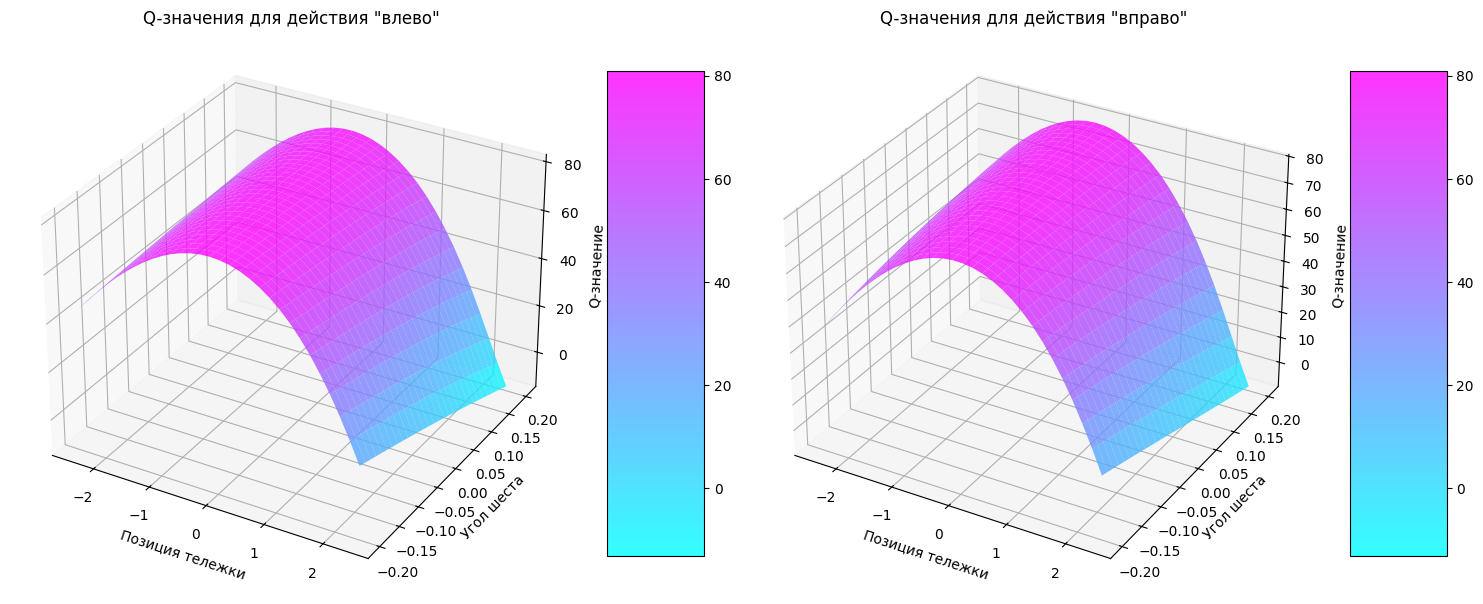

In [20]:
# 3D визуализация ландшафта значений действий
visualize_action_value_landscape(ppo)